In [1]:
import pandas as pd
import numpy as np
import itertools as it
import functools as ft
import multiprocessing as mp

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.coordinate_descent import LinearModelCV
from sklearn.linear_model import ElasticNetCV
from sklearn.base import RegressorMixin
from sklearn.model_selection import cross_validate
from sklearn.metrics import *

from tools import helpers as h

from scipy.stats import norm

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
louv = pd.read_csv('../results/networkClusters/louvain_small_clusters.txt', sep='\t', index_col=0)
rand = pd.read_csv('../results/sensitivityNetworkClusters/sensitivity_randscores.tsv', sep='\t')
rand.index=louv.index
rand.columns = louv.index.values

In [3]:
from umap import UMAP
import seaborn as sns
sns.set()

In [4]:
u = UMAP(metric='cosine', n_neighbors=5, min_dist=.01)
u_coords = u.fit_transform(rand.values)

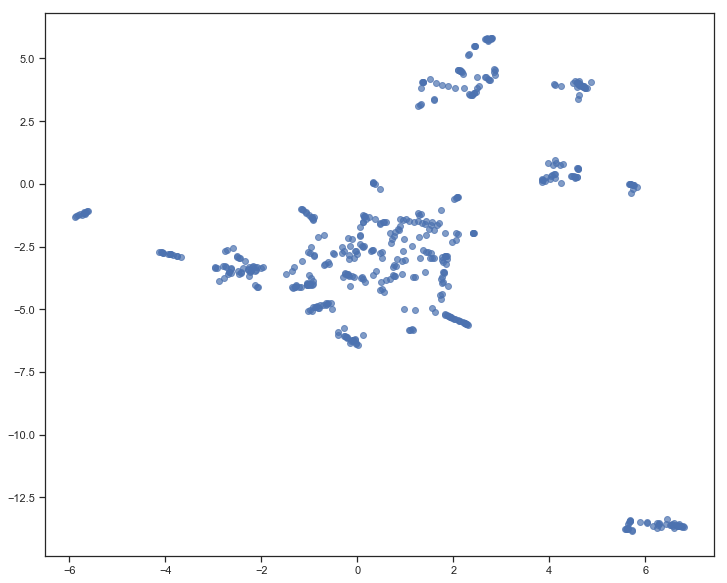

In [35]:
fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(u_coords[:, 0], u_coords[:, 1], alpha=0.7)
plt.show()

In [6]:
sns.set_style('ticks')

In [7]:
# frequency of identical
np.sum((rand==1).sum())/(517**2)

0.5567831074230515

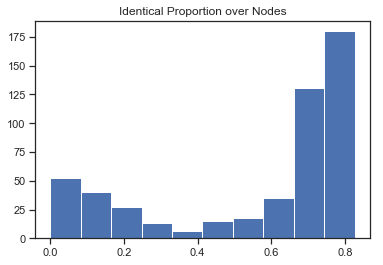

In [8]:
plt.hist((rand==1).sum()/517.)
plt.title('Identical Proportion over Nodes')
plt.show()

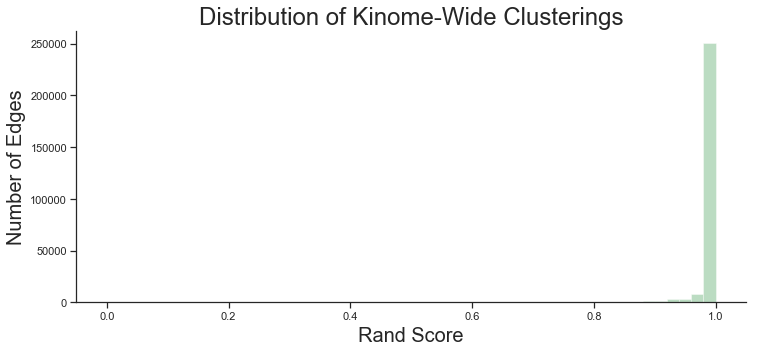

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
sns.distplot(rand.values.flatten(), kde=False, color='g')
#ax.set_title('')
plt.title('Distribution of Kinome-Wide Clusterings', size=24)
plt.ylabel('Number of Edges', size=20)
plt.xlabel('Rand Score', size=20) 
sns.despine()
plt.show()

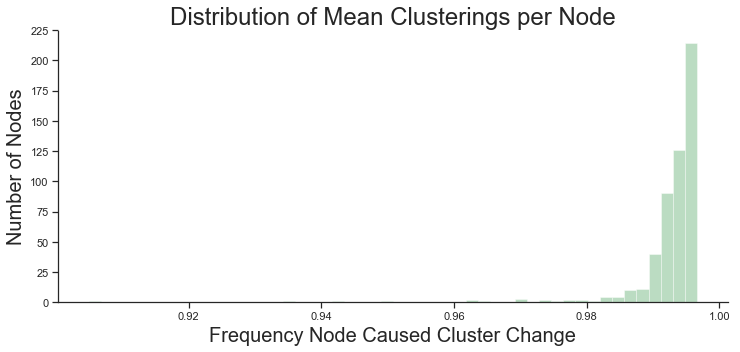

In [10]:
fig, ax = plt.subplots(figsize=(12,5))
sns.distplot(rand.mean(axis=1), kde=False, color='g')
#ax.set_title('')
plt.title('Distribution of Mean Clusterings per Node', size=24)
plt.ylabel('Number of Nodes', size=20)
plt.xlabel('Frequency Node Caused Cluster Change', size=20) 
sns.despine()
plt.show()

In [12]:
mean_nonzero = np.mean(rand[rand !=1], axis=1)
nonzero_count = np.sum((rand != 1).values, axis=1)

In [13]:
network = pd.read_csv('../data/interactionNetworks/kin_anscombe_weighted.csv', sep='\t', header=None)
network.head()

,0,1,2
0,MST1R,YES1,1.224745
1,TYRO3,YES1,1.224745
2,FGR,SRC,2.345208
3,ATR,FLT1,1.224745
4,LYN,PRKCD,3.082207


In [14]:
nodelist = pd.DataFrame(pd.concat([network.iloc[:, 0], network.iloc[:, 1]], axis=0, ignore_index=True))
nodelist.columns = ['Node']
nodelist['Degree'] = ''
degree = nodelist.groupby('Node').agg(len)

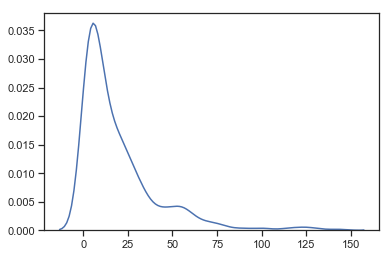

In [15]:
sns.kdeplot(degree.values[:, 0])
plt.show()

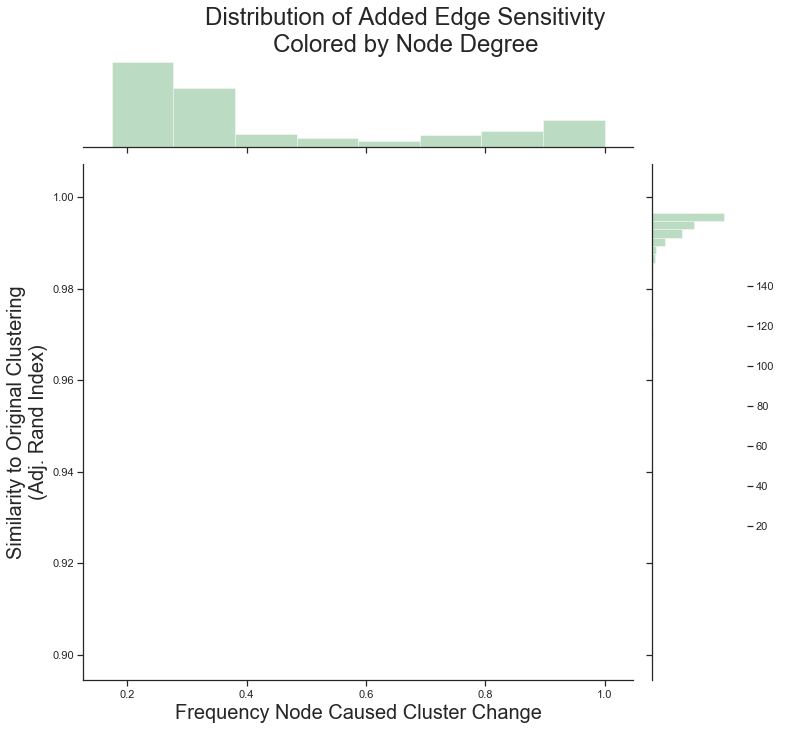

In [16]:
g = sns.jointplot(nonzero_count/517., rand.mean(axis=0), color='g', height=10, kind='scatter', alpha=0)
points = g.ax_joint.scatter(nonzero_count/517., rand.mean(axis=0), c=degree.loc[louv.index].values[:, 0], cmap='viridis_r', alpha=0)
g.ax_joint.set_ylabel('Similarity to Original Clustering\n(Adj. Rand Index)', size=20)
g.ax_joint.set_xlabel('Frequency Node Caused Cluster Change', size=20)

plt.subplots_adjust(top=0.91)
g.fig.suptitle('Distribution of Added Edge Sensitivity\nColored by Node Degree', size=24)

cbar = plt.colorbar(points)
cbar.outline.set_visible(False)
#cbar.ax.axes.set_visible(False)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Node Degree', rotation=270, fontsize=20, color='white')

plt.show()

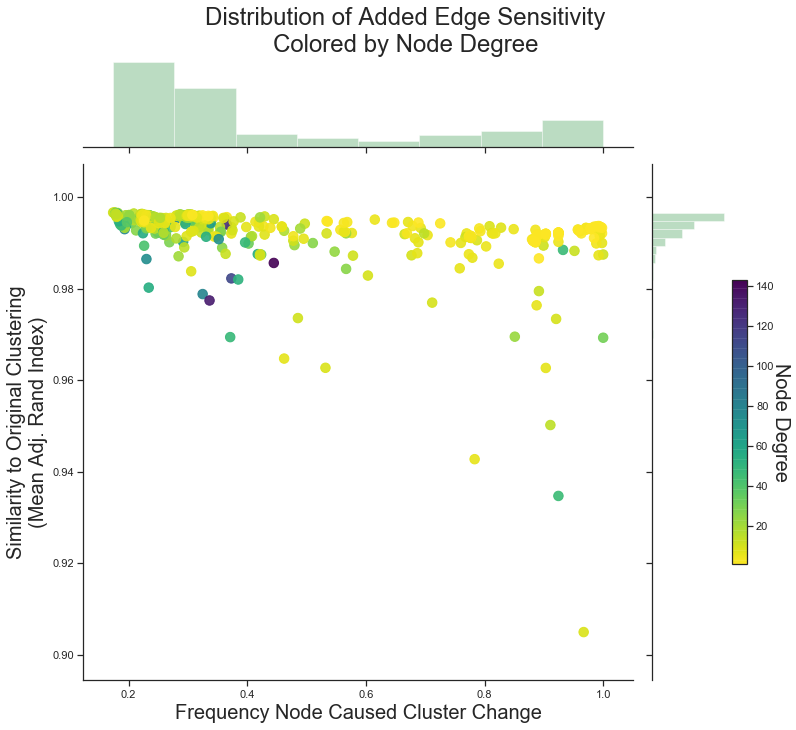

In [17]:
g = sns.jointplot(nonzero_count/517., rand.mean(axis=0), color='g', height=10, kind='scatter', alpha=0)
points = g.ax_joint.scatter(nonzero_count/517., rand.mean(axis=0), c=degree.loc[louv.index].values[:, 0], cmap='viridis_r', alpha=0.9, s=90)
g.ax_joint.set_ylabel('Similarity to Original Clustering\n(Mean Adj. Rand Index)', size=20)
g.ax_joint.set_xlabel('Frequency Node Caused Cluster Change', size=20)

plt.subplots_adjust(top=0.91)
g.fig.suptitle('Distribution of Added Edge Sensitivity\nColored by Node Degree', size=24)

cbar = plt.colorbar(points)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Node Degree', rotation=270, fontsize=20)

plt.show()

In [18]:
dark = pd.read_csv('../data/miscReference/dark_kinases.csv')
dark.head()

,hgnc_id,symbol,ensembl_gene_id,class,name,uniprot_ids,kinase_com_name
0,HGNC:19038,ADCK1,ENSG00000063761,Dark,aarF domain containing kinase 1,Q86TW2,ADCK1
1,HGNC:19039,ADCK2,ENSG00000133597,Dark,aarF domain containing kinase 2,Q7Z695,ADCK2
2,HGNC:21738,ADCK5,ENSG00000173137,Dark,aarF domain containing kinase 5,Q3MIX3,ADCK5
3,HGNC:20565,ALPK2,ENSG00000198796,Dark,alpha kinase 2,Q86TB3,AlphaK2
4,HGNC:17574,ALPK3,ENSG00000136383,Dark,alpha kinase 3,Q96L96,AlphaK1


In [19]:
import matplotlib.cm as cm

In [20]:
prgn = cm.get_cmap('PRGn')


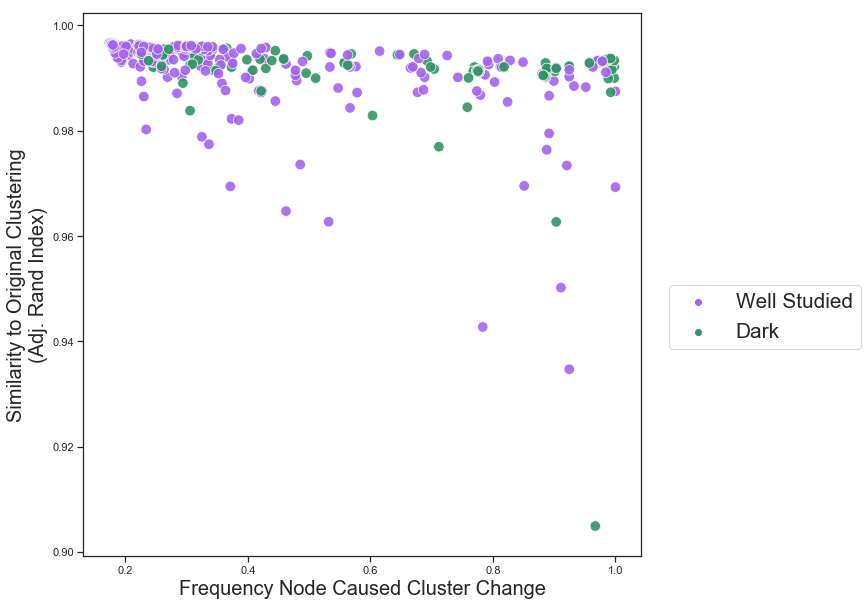

In [21]:
l = louv.merge(dark[['symbol', 'class']], left_index=True, right_on='symbol', how='left')
fig, ax = plt.subplots(figsize=(10,10))
g = sns.scatterplot(nonzero_count/517., rand.mean(axis=0), ax=ax, hue=(l['class'].fillna('Well Studied')).values, alpha=.9, s=110,
                   palette=sns.diverging_palette(280, 145, s=85, l=55, n=2))
g.set_ylabel('Similarity to Original Clustering\n(Adj. Rand Index)', size=20)
g.set_xlabel('Frequency Node Caused Cluster Change', size=20)
 
#plt.setp(ax.get_legend().get_texts(), fontsize='26') 
#plt.legend(loc='lower left')
plt.legend(bbox_to_anchor=(1.05, .5), loc=2, borderaxespad=0., fontsize='xx-large')
#sns.fig.legend
plt.show()

In [22]:
color = pd.read_csv('../results/networkClusters/louvain_clusters.txt', sep='\t')
color.head()

,names,cluster
0,MST1R,3
1,YES1,3
2,TYRO3,3
3,FGR,3
4,SRC,3


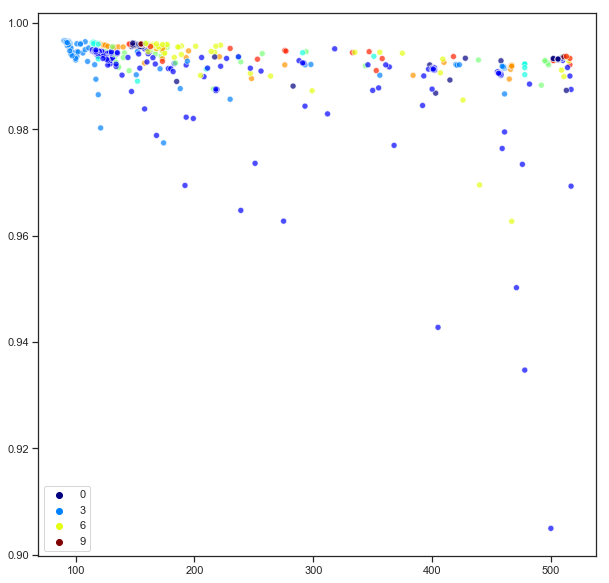

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(nonzero_count, rand.mean(axis=0), ax=ax, hue=color['cluster'].values, palette='jet', alpha=0.7)
plt.show()

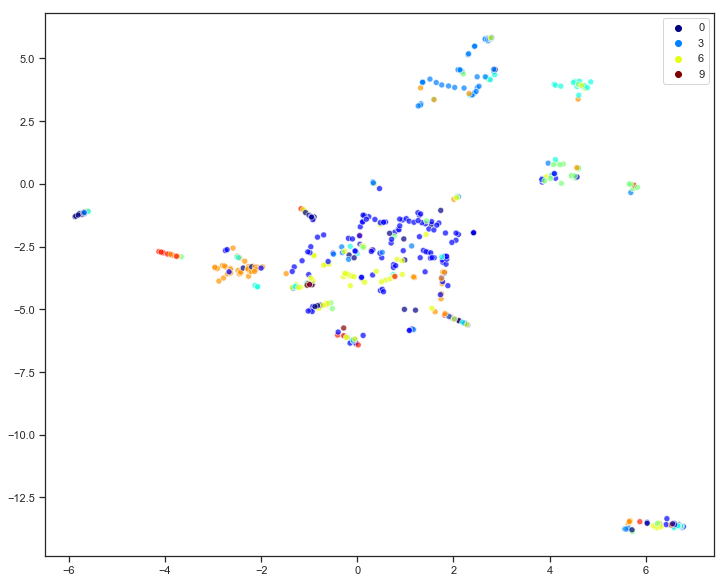

In [36]:
fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(u_coords[:, 0], u_coords[:, 1], ax=ax, hue=color['cluster'].values, palette='jet', alpha=0.7)
plt.show()

### Individual sensitivity Analysis

In [46]:
# these are the kinases with the largest change 
display(rand.mean(axis=0)[rand.mean(axis=0) < 0.95])
low_rand_ids = rand.mean(axis=0)[rand.mean(axis=0) < 0.95].index.tolist()

display(louv.loc[low_rand_ids])

CSNK2A1    0.934692
RIOK3      0.904923
BRD3       0.942731
dtype: float64

,cluster
names,
CSNK2A1,2
RIOK3,2
BRD3,2


In [38]:
rand[rand > 0].min(axis=0).min(axis=0)

0.628465242149574

In [39]:
np.where(rand == rand[rand > 0].min(axis=0).min(axis=0))

(array([  3, 128]), array([128,   3]))

In [40]:
(rand.index[3], rand.index[128])

('FGR', 'MAPK11')

0.628465242149574
MAPK11


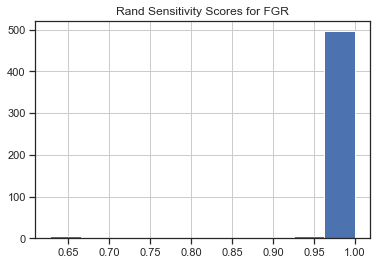

In [41]:
rand_fgr = rand.loc['FGR']
print(rand_fgr[rand_fgr > 0].min())
print(rand_fgr[rand_fgr > 0].idxmin())

rand_fgr[rand_fgr > 0].hist()
plt.title('Rand Sensitivity Scores for FGR')
plt.show()


0.628465242149574
FGR


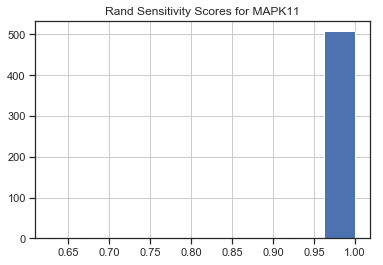

In [45]:
rand_mapk11 = rand.loc['MAPK11']
print(rand_mapk11[rand_mapk11 > 0].min())
print(rand_mapk11[rand_mapk11 > 0].idxmin())

rand_mapk11[rand_mapk11 > 0].hist()
plt.title('Rand Sensitivity Scores for MAPK11')
plt.show()

In [33]:
rand[rand > 0].min(axis=0).idxmin(axis=0)

'FGR'

0.740129499682193
BRSK2


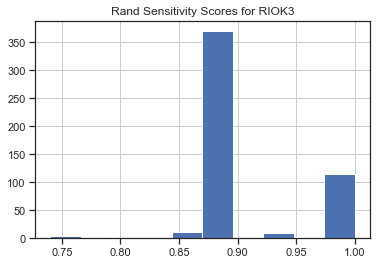

In [47]:
rand_riok3 = rand.loc['RIOK3']
print(rand_riok3[rand_riok3 > 0].min())
print(rand_riok3[rand_riok3 > 0].idxmin())

rand_riok3[rand_riok3 > 0].hist()
plt.title('Rand Sensitivity Scores for RIOK3')
plt.show()

In [49]:
# check that it's not certain subclusters causing the issue
pd.DataFrame(rand_riok3[rand_riok3 > 0]).merge(louv, left_index=True, right_index=True).groupby('cluster').agg(np.mean)

,RIOK3
cluster,
1,0.946030
2,0.896992
3,0.885698
4,0.881487
5,0.881681
6,0.882159
7,0.883211
8,0.880251
9,0.926277


In [43]:
# check that it's not certain subclusters causing the issue
pd.DataFrame(rand.mean(axis=1)).merge(louv, left_index=True, right_index=True).groupby('cluster').agg(np.mean)

,0
cluster,
1,0.994644
2,0.989105
3,0.994618
4,0.986944
5,0.995124
6,0.995091
7,0.995326
8,0.993929
9,0.987676


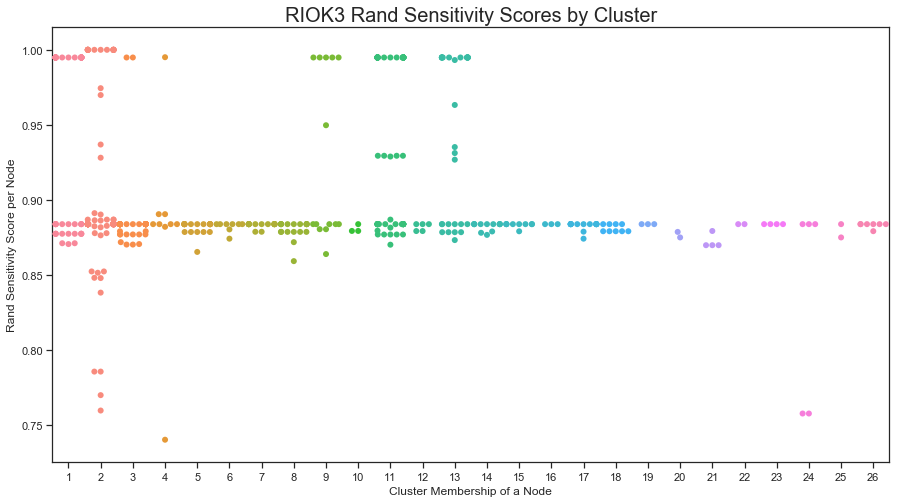

In [51]:
fig, ax = plt.subplots(figsize=(15,8))
sns.swarmplot(data=pd.DataFrame(rand_riok3[rand_riok3>0]).merge(louv, how='left', left_index=True, right_index=True), x='cluster', y='RIOK3', dodge=True, size=6, ax=ax)
plt.title('RIOK3 Rand Sensitivity Scores by Cluster', fontsize=20)
plt.xlabel('Cluster Membership of a Node')
plt.ylabel('Rand Sensitivity Score per Node')
plt.show()

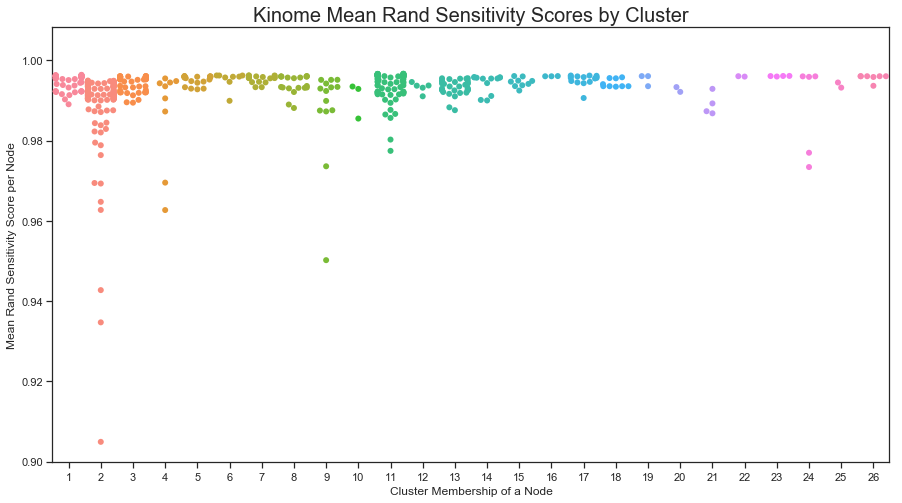

In [44]:
fig, ax = plt.subplots(figsize=(15,8))
sns.swarmplot(data=pd.DataFrame(rand.mean(axis=1)).merge(louv, left_index=True, right_index=True), x='cluster', y=0, dodge=True, size=6, ax=ax)
plt.title('Kinome Mean Rand Sensitivity Scores by Cluster', fontsize=20)
plt.xlabel('Cluster Membership of a Node')
plt.ylabel('Mean Rand Sensitivity Score per Node')
plt.show()

### Network Properties (needs to be moved)

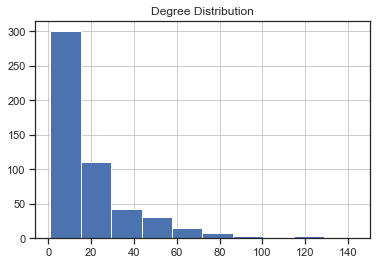

In [33]:
degree.hist()
plt.title('Degree Distribution')
plt.show()

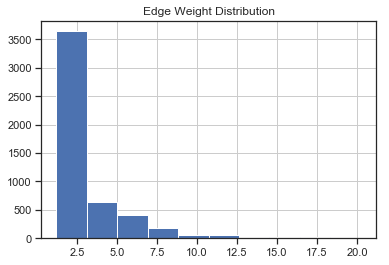

In [34]:
network[2].hist()
plt.title('Edge Weight Distribution')
plt.show()

In [45]:
network_rev = network.copy()
network_rev[1], network_rev[0] = (network_rev[0], network_rev[1])

agg_net = pd.DataFrame(pd.concat([network, network_rev], axis=0, ignore_index=True))

Text(0.5, 1.0, 'Distribution of Edge Weight Sums per Node')

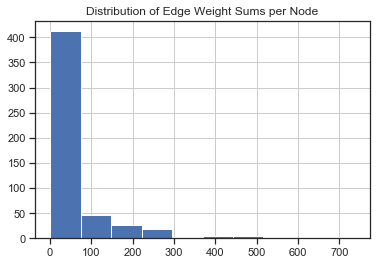

In [49]:
agg_net.groupby(1).agg(sum).hist()
plt.title('Distribution of Edge Weight Sums per Node')

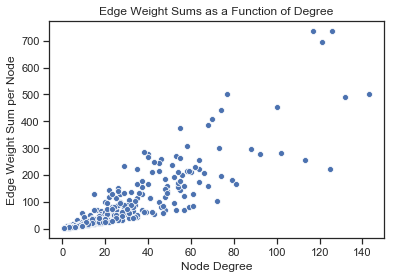

In [64]:
sns.scatterplot(x = degree.values[:, 0], y = agg_net.groupby(1).agg(sum).values[:, 0])
plt.title('Edge Weight Sums as a Function of Degree')
plt.xlabel('Node Degree')
plt.ylabel('Edge Weight Sum per Node')
plt.show()

In [66]:
import networkx as nx

In [68]:
network.columns = ['Source', 'Target', 'Weight']

In [71]:
g = nx.from_pandas_edgelist(network, source='Source', target='Target', edge_attr='Weight').to_undirected()


In [80]:
btwn = pd.DataFrame.from_dict(nx.betweenness_centrality(g), orient='index').sort_index()

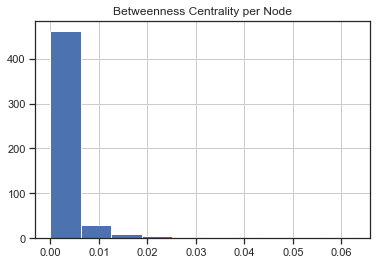

In [83]:
btwn.hist()
plt.title('Betweenness Centrality per Node')
plt.show()

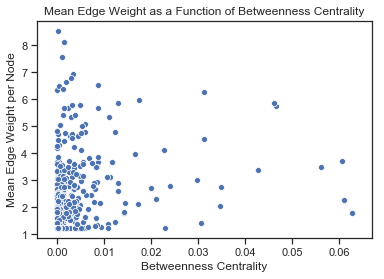

In [85]:
sns.scatterplot(x = btwn.values[:, 0], y = agg_net.groupby(1).agg(sum).values[:, 0]/degree.values[:, 0])
plt.title('Mean Edge Weight as a Function of Betweenness Centrality')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Mean Edge Weight per Node')
plt.show()